In [5]:
using AutomotiveDrivingModels
using AutoViz
using Reactive
using Interact
using SplineUtils
using SplineRaceWay
using HierarchicalRecedingHorizonController
using NearestNeighbors

# import PyPlot

/Users/kyle/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [7]:
# scene parameters
scene = Scene()
framerate = 24
Δt = 1.0/framerate # size of rendering timesteps
n_integration_sub_steps = 3 # sub steps for smoother integration
context = IntegratedContinuous(Δt, n_integration_sub_steps) # integrated continuous context

#car parameters
car_length = 4.8 # front wheel to back wheel
car_width = 2.5
v⁰  = 0.0 # initial velocity
δ⁰ = 0.0 # initical steering angle

############### INITIALIZE TRACK ################

lane_width = 10.0*DEFAULT_LANE_WIDTH
radius = 45.0
edge_buffer = 0.25
T_MAX = lane_width/2.0 - car_width/2.0 - edge_buffer # max allowable projection distance from center of lane
base_speed= 0.0

# spline control points
# Pts = 40*[0 -1 -2 -3 -3 -3 -2 -1 -1 -1 -2 -3 -4 -5 -5 -5 -5 -5 -5 -4 -3 -2 -1 -1 -1 0 1 1 1 2 3 4 5 5 5 5 5 5 5 4 3 3 3 3 2 1 0; 
#          0 0 0 0 -1 -2 -2 -2 -3 -4 -4 -4 -4 -4 -3 -2 -1 0 1 2 3 4 4 3 2 2 2 3 4 4 4 4 3 2 1 0 -1 -2 -3 -4 -3 -2 -1 0 0 0 0]
# Pts = 50*[0 -1 -2 -3 -3.5 -3 -2 -1 -0.5 -1 -2 -3 -4 -5 -5.5 -5 -4.5 -5 -5 -4 -3 -2 -1 -1 -1 0 1 1 1 2 3 4 5 5 5 5 5 5 5 4 3 3 3 3 2 1 0; 
#        0 0 0 0 -1 -2 -2 -2 -3 -4 -4 -4 -4 -4 -3 -2 -1 0 1 2 3 4 4 3 2 2 2 3 4 4 4 4 3 2 1 0 -1 -2 -3 -4 -3 -2 -1 0 0 0 0]
Pts = 50*[0 -1 -2 -3 -3.5 -3 -2 -1 -0.5 -1 -2 -3 -4 -5 -6 -6.5 -6 -5.5 -6 -6 -5 -4 -3 -2 -1.5 -1 0 1 1.5 2 3 4 5 6 6 6 7 7 7 7 6 5 4 4 4 3 2 1 0; 
       0 0 0 0 -1 -2 -2 -2 -3 -4 -4 -4 -4 -4 -4 -3 -2 -1 0 1 2 3 4 4 3 2 2 2 3 4 4 4 4 3 2 1 0 -1 -2 -3 -4 -4 -3 -2 -1 0 0 0 0]

degree = 3 # degree of spline
num_points = 10001
num_samples = 420
lane_width = 20.0
track = Raceway(Pts,degree,num_points,num_samples,lane_width)
track;

In [8]:
roadind1 = RoadIndex(CurveIndex(12,0),LaneTag(1,1))
roadind2 = RoadIndex(CurveIndex(4,0),LaneTag(1,1))
roadind3 = RoadIndex(CurveIndex(11,0),LaneTag(1,1))

vehstate1 = VehicleState(Frenet(roadind1, track.roadway), track.roadway, 0.0)
vehstate2 = VehicleState(Frenet(roadind2, track.roadway), track.roadway, 0.0)
vehstate3 = VehicleState(Frenet(roadind3, track.roadway), track.roadway, 0.0)

vehdef1 = VehicleDef(1,AgentClass.CAR, car_length, car_width)
vehdef2 = VehicleDef(2,AgentClass.CAR, car_length, car_width)
vehdef3 = VehicleDef(3,AgentClass.CAR, car_length, car_width)

push!(scene,Vehicle(vehstate1, vehdef1))
push!(scene,Vehicle(vehstate2, vehdef2))
push!(scene,Vehicle(vehstate3, vehdef3))

# models = Dict{Int, DriverModel}()
carcolors = Dict{Int, Colorant}()
carcolors[1] = colorant"red"
carcolors[2] = colorant"blue"
carcolors[3] = colorant"yellow"


# hrhc = HRHC(1,roadway,context)
track.models[1] = mapHRHC(1,track.roadway,context,h=12,v_max=100.0,μ=30.0,a_step=10.0,a_range=[-1,0,1])
track.models[2] = mapHRHC(2,track.roadway,context,h=12,v_max=100.0,μ=25.0,a_step=12.0,a_range=[-1,0,1])
track.models[3] = mapHRHC(3,track.roadway,context,h=12,v_max=100.0,μ=25.0,a_step=15.0,a_range=[-1,0,1])
# track.models[2] = HRHC(2,track.roadway,context,ΔV₊=1.55,ΔV₋=4.05,Δδ=Float64(π)/12,V_MIN=0.0,V_MAX=125.0,V_STEPS=250,k=1)
# track.models[3] = HRHC(3,track.roadway,context,ΔV₊=2.55,ΔV₋=4.05,Δδ=Float64(π)/12,V_MIN=0.0,V_MAX=130.0,V_STEPS=250,k=2)
actions = Array(DriveAction, length(scene))

track.obstacleMap = generateObstacleMap(scene, track.models)
track;

In [4]:
function drawsim(t, dt=NaN)
    # get_actions!(actions, scene, roadway, models)
    k_level = 0 # needs to be updated into a loop
    for k_level in 0:maximum([model.k for (id,model) in track.models])
        for (i, veh) in enumerate(scene)
            model = track.models[veh.def.id]
            observe!(model, scene, track.roadway, veh.def.id, track.tree, track.obstacleMap, k_level)
            actions[i] = rand(model)
        end
    end
    # tick!(scene, roadway, actions, models)
    for (veh, action) in zip(scene, actions)
        model = track.models[veh.def.id]
        context = action_context(model)
        veh.state = propagate(veh, action, context, track.roadway)
    end
#     zoom = 5.0
    render(scene, track.roadway, cam=FitToContentCamera(), car_colors=carcolors)
#     render(scene, track.roadway, cam=SceneFollowCamera(zoom), car_colors=carcolors)

end

drawsim (generic function with 2 methods)

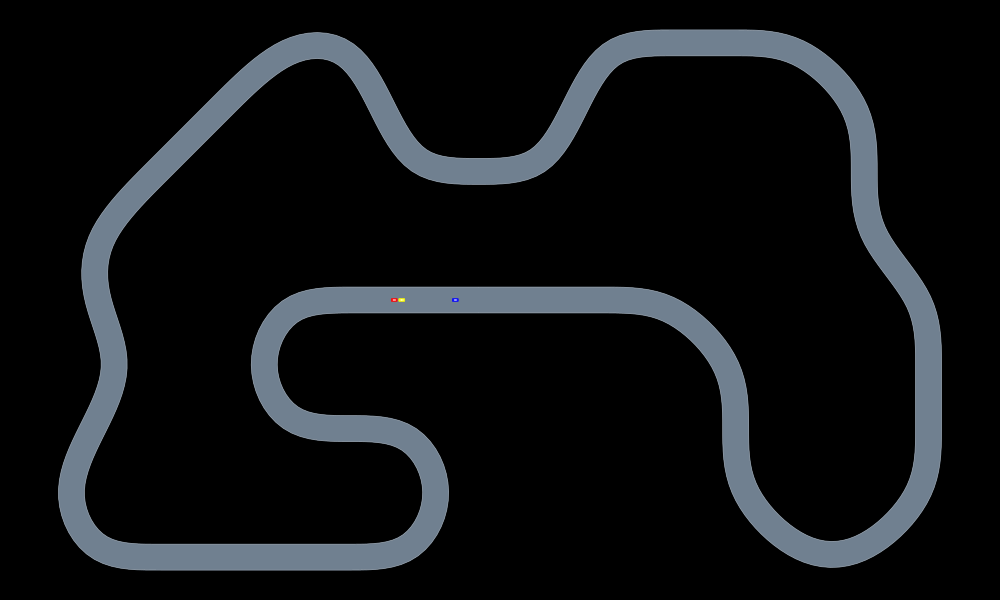

In [5]:
ticks = fps(framerate)
timestamps = map(_ -> time(), ticks)
map(drawsim, timestamps)

In [ ]:
# Plot vehicles, track, trajectory track

function PlotScene(scene,track)
    s_min = Inf
    s_max = 0
    for (id,car) in track.models
        pos = scene.vehicles[id].state.posG
        s,_,_ = kdProject(pos.x,pos.y,pos.θ,track.tree,track.roadway,track.models[id])
        PyPlot.scatter(scene.vehicles[id].state.posG.x,scene.vehicles[id].state.posG.y,c="red")
        PyPlot.plot(track.obstacleMap[1][id][:,1],track.obstacleMap[1][id][:,2],c="red")
        s_min = min(s,s_min)
        s_max = max(s,s_max)
    end
    idx_min = max(Int(div(s_min,track.models[1].Δs)),indmin(track.s))
    idx_max = min(Int(div(s_max+100,track.models[1].Δs)),indmax(track.s))
    # PyPlot.plot(track.x[idx_min:idx_max],track.y[idx_min:idx_max])
    plotSplineRoadway(track.x[idx_min:idx_max],track.y[idx_min:idx_max],track.θ[idx_min:idx_max],track.roadway.segments[1].lanes[1].width)
    PyPlot.axis("equal")
end

PlotScene(scene,track)

## Other stuff

In [ ]:
# check that projection works
function checkProjection(track)
    x_rand = []
    y_rand = []
    σ = 200.0
    for i in 1:10
        for j in 1:length(track.x)
            push!(x_rand, track.x[j] + σ*(rand()-.5))
            push!(y_rand, track.y[j] + σ*(rand()-.5))
        end
    end
    s_rand = []
    t_rand = []
    ϕ_rand = []
    for i in 1:length(x_rand)
        s_val,t_val,ϕ_val = kdProject(x_rand[i],y_rand[i],0,track.tree,track.roadway,track.models[1])
        push!(s_rand,s_val)
        push!(t_rand,t_val)
        push!(ϕ_rand,0)
    end
    PyPlot.scatter(x_rand,y_rand,c=s_rand,edgecolor="none")
#     PyPlot.scatter(x_rand,y_rand,c=log((t_rand/T_MAX).^6),edgecolor="none")
    PyPlot.plot(track.x,track.y,linewidth=2,c="black")
    PyPlot.title("Projection map")

end

checkProjection(track)

In [ ]:
steps = 10
for j in 1:steps
    # get_actions!(actions, scene, roadway, models)
    k_level = 0 # needs to be updated into a loop
    for k_level in 0:maximum([model.k for (id,model) in track.models])
        for (i, veh) in enumerate(scene)
            model = track.models[veh.def.id]
            observe!(model, scene, track.roadway, veh.def.id, track.tree, track.obstacleMap, k_level)
            actions[i] = rand(model)
        end
    end
    # tick!(scene, roadway, actions, models)
    for (veh, action) in zip(scene, actions)
        model = track.models[veh.def.id]
        context = action_context(model)
        veh.state = propagate(veh, action, context, track.roadway)
    end
#     render(scene, track.roadway, cam=FitToContentCamera(), car_colors=carcolors)
end

hrhc = track.models[1]
k_level = hrhc.k
roadway = track.roadway
tree = track.tree
obstacleMap = track.obstacleMap

state = scene.vehicles[hrhc.car_ID].state
hrhc.curve_ind = state.posF.roadind.ind.i
v = state.v # current v
hrhc.v = v
trajectory = zeros(hrhc.h,3)
action_selected = false
δ_cmd = 1
a_cmd = 3

i = 0
for i in 0:(hrhc.h-1)
    if action_selected
        break # out of for loop
    end

    # calculate successor states
    hrhc.successor_states = getSuccessorStates(hrhc.motion_map[hrhc.v_cmd], hrhc.car_ID, hrhc.h, scene)

    # project successor states onto track
    s,t,ϕ = loopProjectionKD(hrhc, scene, roadway, tree)

    # optimization objective
    objective = calculateObjective(hrhc, scene, roadway, tree, s, t, ϕ, obstacleMap, k_level, hrhc.h-i,f_t=0.0)

    while (action_selected==false) && (minimum(objective) != Inf)
        index = indmin(objective) # find get a better method of optimizing this
        a_cmd, δ_cmd = ind2sub(s, index)
        hrhc.δ_cmd = δ_cmd

        # compute full trajectory up to horizon
        trajectory = computeTrajectory(hrhc.motion_map[hrhc.v_cmd], hrhc.car_ID, scene, a_cmd, δ_cmd, hrhc.h-i)

        # screen trajectory for collisions / validity
        out_of_bounds = screenTrajectory(trajectory, obstacleMap, scene, roadway, hrhc, tree, k_level)

        if out_of_bounds
            objective[index] = Inf
        else
            action_selected=true
            updateObstacleMap!(obstacleMap, k_level, hrhc.car_ID, trajectory)
        end
    end
end

hrhc.δ_cmd = δ_cmd
# hrhc.v_cmd = hrhc.v_cmd + a_cmd - 2 # assumes 3 options for acceleration
hrhc.v_cmd = hrhc.v_map[hrhc.v_cmd][a_cmd,δ_cmd]

hrhc.δ = hrhc.δ_range[hrhc.δ_cmd] # next δ
hrhc.v = hrhc.v_range[hrhc.v_cmd] # next v

next_state = VehicleState(VecSE2(trajectory[1,1:3]),roadway,hrhc.v)
hrhc.action = NextState(next_state) # action

plotObjectiveHorizon2(hrhc,scene,track.roadway,track.tree,trajectory,track.obstacleMap,track.x,track.y,track.θ)


In [ ]:
scene.vehicles[1].state.v

## Objective Function Calculations

In [4]:
t1 = linspace(-12,12,200)
T_MAX = 10
t_cost = exp(abs(t1/T_MAX).^6)

ϕ1 = linspace(-Float64(π),Float64(π),200)
ϕ_MAX = Float64(π)/2
ϕ_cost = exp(abs(ϕ1/ϕ_MAX).^2)

s1 = linspace(0,1,20)
s_factor = 5
s_cost = s_factor*(1-s1/maximum(s1))

# A = [1 1; 1 1]
# cost_x = (((ϕ1/ϕ_MAX)*A[1,1] + (t1/hrhc.T_MAX)*A[2,1]).*(ϕ1/ϕ_MAX) + ((ϕ1/ϕ_MAX)*A[1,2] + (t1/hrhc.T_MAX)*A[2,2]).*(t1/hrhc.T_MAX))/2
# tϕ_cost = (exp(f_tϕ*cost_x) )/exp(1)

PyPlot.figure(figsize=[12,3])
PyPlot.subplot(1,4,1)
PyPlot.plot(t1,t_cost)
PyPlot.title("t")
PyPlot.subplot(1,4,2)
PyPlot.plot(ϕ1,ϕ_cost)
PyPlot.title("phi")
PyPlot.subplot(1,4,3)
PyPlot.plot(s1,s_cost)
PyPlot.title("s")

LoadError: UndefVarError: PyPlot not defined

In [ ]:
function calculateObjective2(car_ID,s,s₀,t,ϕ,T_MAX;ϕ_MAX=Float64(π),s_factor=1.0)
    s_norm = (s-s₀)/maximum(s)
    t_norm = t/T_MAX
    ϕ_norm = ϕ/ϕ_MAX

    #costs
    t_cost = abs(t_norm).^6
    ϕ_cost = abs(ϕ_norm).^6
    s_factor = 1
    s_cost = s_factor*(1-s_norm)
    A = [1 .5; #  [ϕ t] [a1 a2] [ϕ]
        .5 0] #         [a2 a3] [t]
    tϕ_cost = A[1,1]*(ϕ_norm).^2 + (A[1,2]+A[2,1])*(ϕ_norm).*(t_norm) + A[2,2]*(t_norm).^2

    objective = 1+s_cost+t_cost+ϕ_cost+tϕ_cost
    return objective
end

In [ ]:
θ = linspace(-Float64(π),Float64(π),360)
r = linspace(1.0,20.0,20)
x = [cos(i) for i in θ]*[i for i in r]'
y = [sin(i) for i in θ]*[i for i in r]'
R = [1 for i in θ]*[i for i in r]'
Θ = [i for i in θ]*[1 for i in r]'
s = x
t = y-10
ϕ = Θ

car_ID = 1
s₀ = 0 # scene.vehicles[car_ID].state.posF.s

T_MAX = 10
ϕ_MAX = Float64(π)

s_norm = s/maximum(s)
t_norm = t/T_MAX
ϕ_norm = ϕ/ϕ_MAX

#costs
t_cost = abs(t_norm).^6
ϕ_cost = abs(ϕ_norm).^6
s_factor = 1
s_cost = s_factor*(1-s_norm)
A = [1 .5; #  [ϕ t] [a1 a2] [ϕ]
    .5 0] #         [a2 a3] [t]
tϕ_cost = A[1,1]*(ϕ_norm).^2 + (A[1,2]+A[2,1])*(ϕ_norm).*(t_norm) + A[2,2]*(t_norm).^2

objective = calculateObjective2(car_ID,s,s₀,t,ϕ,T_MAX)

PyPlot.figure(figsize=[12,6])
PyPlot.subplot(2,4,1)
PyPlot.scatter(x,y,c=s,edgecolor="none",s=4)
PyPlot.axis("equal")
PyPlot.subplot(2,4,2)
PyPlot.scatter(x,y,c=t,edgecolor="none",s=4)
PyPlot.axis("equal")
PyPlot.subplot(2,4,3)
PyPlot.scatter(x,y,c=ϕ,edgecolor="none",s=4)
PyPlot.axis("equal")
PyPlot.subplot(2,4,4)
PyPlot.scatter(x,y,c=s,edgecolor="none",s=4)
PyPlot.axis("equal")

PyPlot.subplot(2,4,1+4)
PyPlot.scatter(x,y,c=s_cost,edgecolor="none",s=4)
PyPlot.axis("equal")
PyPlot.subplot(2,4,2+4)
PyPlot.scatter(x,y,c=t_cost,edgecolor="none",s=4)
PyPlot.axis("equal")
PyPlot.subplot(2,4,3+4)
PyPlot.scatter(x,y,c=tϕ_cost,edgecolor="none",s=4)
PyPlot.axis("equal")
PyPlot.subplot(2,4,4+4)
PyPlot.scatter(x,y,c=log(objective),edgecolor="none",s=4)
PyPlot.scatter(x[indmin(objective)],y[indmin(objective)],c="white",s=30)
PyPlot.axis("equal")

In [ ]:
function ObjectiveFunction(x,y,r,s,t,ϕ, scene, roadway, tree) #, obstacleMap, k_level, h; f_ϕ=0.0, f_t=0.1, f_tϕ=3.0)
    """
    Calculates the value of the optimization objective function for every state
      in hrhc.successor_states
    """
    state = scene.vehicles[hrhc.car_ID].state
    dS = s - state.posF.s
    dS = dS / maximum(dS) # normalize
    ϕMAX = Float64(π)/2

    # penalize large t (proximity to edge of track)
    cost_t = (exp(((10-h+f_t)*abs(t/hrhc.T_MAX).^2)) )/exp(f_t) + Inf*(t.>hrhc.T_MAX)
    # penalize large ϕ (steering away from forward direction on the track)
    cost_ϕ = (exp(((10-h+f_ϕ)*abs(ϕ/ϕMAX).^2)) )/exp(f_ϕ)
    # penalize when t and ϕ have the same sign
    A = [1 1; 1 1]
    cost_x = (((ϕ/ϕMAX)*A[1,1] + (t/hrhc.T_MAX)*A[2,1]).*(ϕ/ϕMAX) + ((ϕ/ϕMAX)*A[1,2] + (t/hrhc.T_MAX)*A[2,2]).*(t/hrhc.T_MAX))/2
    cost_tϕ = (exp(f_tϕ*cost_x) )/exp(1)
    eligibility_mask = ((hrhc.successor_states[:,:,1] .== state.posG.x).*(hrhc.successor_states[:,:,2] .== state.posG.y))

    # obstacles
    collisionCost = zeros(size(cost_t))
    threshold_dist = hrhc.car_length*4 # must be at least this close before we care to calculate collision cost
    if k_level >= 1
        for (id,car) in obstacleMap[k_level - 1]
            if id != hrhc.car_ID
                s1 = scene.vehicles[hrhc.car_ID].state.posF.s
                s2 = scene.vehicles[id].state.posF.s
                diff = state.posG - state2.posG
                if (norm([diff.x, diff.y]) < threshold_dist) && (s1 <= s2) # don't care if opponent is behind us
                    pos = VecSE2(car[h,1:3]) # x,y,θ of opponent at time step h
                    ΔX = hrhc.successor_states[:,:,1] - pos.x # Δx, with opponent at origin
                    ΔY = hrhc.successor_states[:,:,2] - pos.y # Δy with opponent at origin
                    Δθ = hrhc.successor_states[:,:,3] - pos.θ # Δθ with opponent at origin
                    pts = [hrhc.car_length hrhc.car_length -hrhc.car_length -hrhc.car_length 0;
                        -hrhc.car_width hrhc.car_width hrhc.car_width -hrhc.car_width 0]/1.8
                    pX = zeros(size(pts,2),size(hrhc.successor_states,1),size(hrhc.successor_states,2))
                    pY = zeros(size(pX))
                    for i in 1:size(pts,2)
                        pX[i,:,:] = pts[1,i]*cos(Δθ) - pts[2,i]*sin(Δθ) + ΔX
                        pY[i,:,:] = pts[1,i]*sin(Δθ) + pts[2,i].*cos(Δθ) + ΔY
                    end

                    collisionFlag = (maximum((abs(pX) .< hrhc.car_length/1.0),1)[1,:,:]).*(maximum((abs(pY) .< hrhc.car_width/1.9),1)[1,:,:])
                    collisionCost = .001+(collisionFlag .>= 1)./(minimum(abs(pX),1)[1,:,:].*minimum(abs(pY),1)[1,:,:])
                    # collisionCost = Inf.*collisionFlag
                end
            end
        end
    end

    objective = cost_t + cost_ϕ + cost_tϕ + 1 - dS + collisionCost + Inf * eligibility_mask
    return objective
end

In [ ]:
function plotSplineRoadway2(x,y,θ,lane_width)
    perp_lines1 = zeros(2,length(x))
    perp_lines2 = zeros(2,length(x))

    perp_lines1[1,:] = x + (lane_width/2.0)*sin(θ)
    perp_lines1[2,:] = y - (lane_width/2.0)*cos(θ)
    perp_lines2[1,:] = x - (lane_width/2.0)*sin(θ)
    perp_lines2[2,:] = y + (lane_width/2.0)*cos(θ)

    # PyPlot.figure()
    # PyPlot.scatter(x,y)
    PyPlot.plot(x,y)
    PyPlot.plot(perp_lines1[1,:],perp_lines1[2,:],color="green")
    PyPlot.plot(perp_lines2[1,:],perp_lines2[2,:],color="green")
    PyPlot.axis("equal")
    # PyPlot.show()
end

In [ ]:
function plotObjectiveHorizon2(hrhc,scene,roadway,tree,trajectory,obstacleMap,xR,yR,θR)
    lo=hrhc.curve_ind
    hi=hrhc.curve_ind + Int(1+div(hrhc.v_range[end]*hrhc.Δt*hrhc.h,hrhc.Δs))
    lane_width = roadway.segments[1].lanes[1].width

    x = zeros(hrhc.h,size(hrhc.successor_states,1),size(hrhc.successor_states,2))
    y = zeros(size(x))
    θ = zeros(size(x))
    s = zeros(size(x))
    t = zeros(size(x))
    ϕ = zeros(size(x))
    objective = zeros(size(x))

    for i in 1:hrhc.h
        getSuccessorStates(hrhc.motion_map[hrhc.v_cmd], hrhc.car_ID, hrhc.h, scene)
        x[i,:,:] = copy(hrhc.successor_states[:,:,1])
        y[i,:,:] = copy(hrhc.successor_states[:,:,2])
        θ[i,:,:] = copy(hrhc.successor_states[:,:,3])
        s[i,:,:], t[i,:,:], ϕ[i,:,:] = loopProjectionKD(hrhc,scene,roadway,tree)
        objective[i,:,:] = calculateObjective(hrhc, scene, roadway, tree,s[i,:,:],t[i,:,:],ϕ[i,:,:],obstacleMap,hrhc.k,hrhc.h)
    end
    
    PyPlot.figure(figsize=[12,4])

    PyPlot.subplot(141) # ϕ
    plotSplineRoadway(xR[lo:hi],yR[lo:hi],θR[lo:hi],lane_width)
    PyPlot.scatter(x,y,c=ϕ,edgecolor="none")
    PyPlot.plot(trajectory[:,1],trajectory[:,2],color="red")
    PyPlot.axis("off")
    PyPlot.title("|phi|")

    PyPlot.subplot(142) # s
    plotSplineRoadway(xR[lo:hi],yR[lo:hi],θR[lo:hi],lane_width)
    PyPlot.scatter(x,y,c=s,edgecolor="none")
    PyPlot.plot(trajectory[:,1],trajectory[:,2],color="red")
    PyPlot.axis("off")
    PyPlot.title("s")

    PyPlot.subplot(143) # t
    plotSplineRoadway(xR[lo:hi],yR[lo:hi],θR[lo:hi],lane_width)
    PyPlot.scatter(x,y,c=t,edgecolor="none")
    PyPlot.plot(trajectory[:,1],trajectory[:,2],color="red")
    PyPlot.axis("off")
    PyPlot.title("t")

    PyPlot.subplot(144) # objective
    plotSplineRoadway(xR[lo:hi],yR[lo:hi],θR[lo:hi],lane_width)
    PyPlot.scatter(x,y,c=log(objective),edgecolor="none")
    PyPlot.plot(trajectory[:,1],trajectory[:,2],color="red")
    PyPlot.axis("off")
    PyPlot.title("log objective")
#     return objective
end

In [ ]:
function plot_stϕ(hrhc,roadway,scene,x,y,θ,trajectory,s,t,ϕ,objective)
    lo=hrhc.curve_ind
    hi=hrhc.curve_ind + Int(1+2*div(hrhc.V_MAX*hrhc.Δt*hrhc.h,hrhc.Δs))
    if hi > length(roadway.segments[1].lanes[1].curve)
        lo = length(roadway.segments[1].lanes[1].curve)
        hi=hrhc.curve_ind + Int(1+2*div(hrhc.V_MAX*hrhc.Δt*hrhc.h,hrhc.Δs))
    end
    lane_width = roadway.segments[1].lanes[1].width

    PyPlot.figure(figsize=[12,4])
    PyPlot.subplot(141)
    plotSplineRoadway(x[lo:hi],y[lo:hi],θ[lo:hi],lane_width)
    # PyPlot.scatter(Pts[1,:],Pts[2,:],color="red")
    PyPlot.scatter(hrhc.successor_states[:,:,1],hrhc.successor_states[:,:,2],c=abs(ϕ),edgecolor="none")
    PyPlot.plot(trajectory[:,1],trajectory[:,2],color="red")
    PyPlot.scatter(scene.vehicles[hrhc.car_ID].state.posG.x, scene.vehicles[hrhc.car_ID].state.posG.y, c="k", edgecolors="none",s=40)
    PyPlot.axis("off")
    PyPlot.title("|phi|")

    PyPlot.subplot(142)
    plotSplineRoadway(x[lo:hi],y[lo:hi],θ[lo:hi],lane_width)
    # PyPlot.scatter(Pts[1,:],Pts[2,:],color="red")
    PyPlot.scatter(hrhc.successor_states[:,:,1],hrhc.successor_states[:,:,2],c=abs(t),edgecolor="none")
    PyPlot.plot(trajectory[:,1],trajectory[:,2],color="red")
    PyPlot.scatter(scene.vehicles[hrhc.car_ID].state.posG.x, scene.vehicles[hrhc.car_ID].state.posG.y, c="k", edgecolors="none",s=40)
    PyPlot.axis("off")
    PyPlot.title("|t|")

    PyPlot.subplot(143)
    plotSplineRoadway(x[lo:hi],y[lo:hi],θ[lo:hi],lane_width)
    # PyPlot.scatter(Pts[1,:],Pts[2,:],color="red")
    PyPlot.scatter(hrhc.successor_states[:,:,1],hrhc.successor_states[:,:,2],c=s,edgecolor="none")
    PyPlot.scatter(scene.vehicles[hrhc.car_ID].state.posG.x, scene.vehicles[hrhc.car_ID].state.posG.y, c="k", edgecolors="none",s=40)
    PyPlot.plot(trajectory[:,1],trajectory[:,2],color="red")
    PyPlot.axis("off")
    PyPlot.title("s")


    PyPlot.subplot(144)
    plotSplineRoadway(x[lo:hi],y[lo:hi],θ[lo:hi],lane_width)
    # PyPlot.scatter(Pts[1,:],Pts[2,:],color="red")
    PyPlot.scatter(hrhc.successor_states[:,:,1],hrhc.successor_states[:,:,2],c=log(objective),edgecolor="none")
    PyPlot.plot(trajectory[:,1],trajectory[:,2],color="red")
    PyPlot.scatter(scene.vehicles[hrhc.car_ID].state.posG.x, scene.vehicles[hrhc.car_ID].state.posG.y, c="k", edgecolors="none",s=40)
    PyPlot.axis("off")
    PyPlot.title("objective")
end
function plotHRHCInfo(hrhc,models,scene,roadway,trajectory,cmd,x,y,Θ,s,t,ϕ,objective)
    lo = hrhc.curve_ind
    hi = hrhc.curve_ind + Int(1+2*div(hrhc.V_MAX*hrhc.Δt*hrhc.h,hrhc.Δs))
    lane_width = roadway.segments[1].lanes[1].width
    if hi > length(roadway.segments[1].lanes[1].curve)
        lo = length(roadway.segments[1].lanes[1].curve)
        hi=hrhc.curve_ind + Int(1+2*div(hrhc.V_MAX*hrhc.Δt*hrhc.h,hrhc.Δs))
    end
    PyPlot.figure(figsize=[12,10])
    # Plot Raceway
    PyPlot.subplot(221)
    # plotSplineRoadway(x[lo:hi],y[lo:hi],θ[lo:hi],lane_width)
    plotSplineRoadway(x,y,Θ,lane_width)
    PyPlot.scatter(hrhc.successor_states[:,:,1],hrhc.successor_states[:,:,2],color="red")
    PyPlot.plot(trajectory[:,1],trajectory[:,2],color="red")
    PyPlot.scatter(roadway.segments[1].lanes[1].curve[hrhc.curve_ind].pos.x, roadway.segments[1].lanes[1].curve[hrhc.curve_ind].pos.y, c="white", s=40)
    for (id,car) in models
        if id == hrhc.car_ID
            PyPlot.scatter(scene.vehicles[id].state.posG.x,scene.vehicles[id].state.posG.y,c="red",s=20)
        else
            PyPlot.scatter(scene.vehicles[id].state.posG.x,scene.vehicles[id].state.posG.y,c="blue",s=20)
        end
    end
    PyPlot.axis("off")
    PyPlot.title("Raceway with Motion Primitives")

    PyPlot.subplot(222)
    plotSplineRoadway(x[lo:hi],y[lo:hi],Θ[lo:hi],lane_width)
    PyPlot.scatter(scene.vehicles[hrhc.car_ID].state.posG.x, scene.vehicles[hrhc.car_ID].state.posG.y, c="red", edgecolors="none",s=40)
    PyPlot.scatter(hrhc.successor_states[:,:,1], hrhc.successor_states[:,:,2],c=log(objective),edgecolors="none")
    PyPlot.scatter(hrhc.successor_states[cmd[1],cmd[2],1], hrhc.successor_states[cmd[1],cmd[2],2],c="white",s=40)
    PyPlot.plot(trajectory[:,1],trajectory[:,2],color="red")
    PyPlot.axis("off")
    PyPlot.title("Log Objective Function")
end